# 基于单隐层神经网络的手写数字识别（Hangwriting Recongnition Using Single-hidden Layer Neural Network）
## 浙江理工大学 沈炜

** 上一节用单个神经元实现手写数字识别，本节将在此基础上拓展神经网络的深度，使其从包含单个神经元的网络拓展为包含256个神经元的单隐层神经网络。本节我们将掌握： **<br>
- 神经网络的搭建：通过定义全连接操作来简化网络搭建
- 存储模型：在检查点checkpoint保存参数
- 读取模型：通过读取ckpt文件将已训练模型用于预测

## 载入数据

In [1]:
import os
import tensorflow as tf #导入Tensorflow
import tensorflow.examples.tutorials.mnist.input_data as input_data #导入Tensorflow提供的读取MNIST的模块

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) # 读取MNIST数据

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 建立模型

多层神经网络，上一层与下一层神经元之间如果都是全连接，这种网络称为全连接网络（Fully Connected Networks, FCN），有时也称为多层感知机（Multi-Layer Perceptron，MLP）。<br>
<img src='net.jpg'><br>
定义全连接层是构建FCN或MLP的基础，因此，我们先定义全连接层的函数fcn_layer.

In [4]:
def fcn_layer(output_dim,input_dim,inputs, activation=None):
#input_dim为输入神经元数量，output_dim为输出神经元数量
#inputs是输入的二维数组placeholder, activation是激活函数
    W = tf.Variable(tf.random_normal([input_dim, output_dim])) #以正态分布的随机数初始化W
    b = tf.Variable(tf.random_normal([1, output_dim])) #以正态分布的随机数初始化b
    XWb = tf.matmul(inputs, W) + b # 建立表达式：inputs x W + b
    if activation is None: # 默认不使用激活函数
        outputs = XWb
    else: # 若传入激活函数，则用其对输出结果进行变换
        outputs = activation(XWb)
    return outputs

### 构建输入层 

In [6]:
x = tf.placeholder("float", (None, 784))
x

<tf.Tensor 'Placeholder_1:0' shape=(?, 784) dtype=float32>

### 构建隐藏层

In [7]:
# 隐藏层包含256个神经元
h1=fcn_layer(output_dim=256,input_dim=784,inputs=x ,activation=tf.nn.relu)
# 注意这里的输入输出维度

### 构建输出层

In [9]:
pred=fcn_layer(output_dim=10,input_dim=256,inputs=h1,activation=None)
# 注意这里的输入输出维度,输出是10原因是什么？

## 训练模型

### 定义损失函数

In [11]:
y = tf.placeholder("float", (None, 10))
# 交叉熵
loss_function = tf.reduce_mean( 
                  tf.nn.softmax_cross_entropy_with_logits
                         (logits=pred, 
                          labels=y))

### 设置训练参数

In [13]:
train_epochs = 30
batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)
display_step = 1
save_step=5
learning_rate = 0.001
epoch_list=[];loss_list=[];accuracy_list=[]

ckpt_dir = "./ckpt_dir/"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

from time import time
startTime=time()

每个固定间隔（save_step）在检查点保存一个模型（.ckpt文件，检查点文件，checkpoint），可便于随时将模型拿来进行预测。<br>
通常，观察前几次的预测效果就可以粗略估计出神经网络设计得是否合理。

### 选择优化器

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)  

### 定义准确率

In [16]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # 求平均值

### 训练并存储模型

In [17]:
#声明完所有变量后，调用tf.train.Saver，用于保存模型
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(train_epochs):
    for batch in range(total_batch):
        xs, ys = mnist.train.next_batch(batch_size)# 读取批次数据
        sess.run(optimizer,feed_dict={x: xs,y: ys}) # 执行批次训练
           
    #total_batch个批次训练完成后，使用验证数据计算误差与准确率   
    loss,acc = sess.run([loss_function,accuracy],
                        feed_dict={x: mnist.validation.images, y: mnist.validation.labels})
    
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)    
    
    if (epoch+1) % display_step == 0:
        print("Train Epoch:", '%02d' % (epoch+1), "Loss=", "{:.9f}".format(loss)," Accuracy=","{:.4f}".format(acc))
    if (epoch+1) % save_step == 0:
            saver.save(sess, os.path.join(ckpt_dir, 'mnist_h256_model_{:06d}.ckpt'.format(epoch+1)))#存储模型
            print('mnist_h256_model_{:06d}.ckpt saved'.format(epoch+1))

# 显示运行总时间    
duration =time()-startTime
print("Train Finished takes:","{:.2f} seconds".format(duration))

saver.save(sess, os.path.join(ckpt_dir, 'mnist_h256_model.ckpt'))#生成检查点文件
print("Model saved!")

Train Epoch: 01 Loss= 6.056272984  Accuracy= 0.8508
Train Epoch: 02 Loss= 3.960555792  Accuracy= 0.8928
Train Epoch: 03 Loss= 3.073551893  Accuracy= 0.9116
Train Epoch: 04 Loss= 2.589569569  Accuracy= 0.9166
Train Epoch: 05 Loss= 2.245946407  Accuracy= 0.9236
mnist_h256_model_000005.ckpt saved
Train Epoch: 06 Loss= 1.951390624  Accuracy= 0.9308
Train Epoch: 07 Loss= 1.835075021  Accuracy= 0.9318
Train Epoch: 08 Loss= 1.660187125  Accuracy= 0.9370
Train Epoch: 09 Loss= 1.517823935  Accuracy= 0.9382
Train Epoch: 10 Loss= 1.457973838  Accuracy= 0.9396
mnist_h256_model_000010.ckpt saved
Train Epoch: 11 Loss= 1.412962675  Accuracy= 0.9406
Train Epoch: 12 Loss= 1.351998925  Accuracy= 0.9412
Train Epoch: 13 Loss= 1.275559306  Accuracy= 0.9440
Train Epoch: 14 Loss= 1.240844369  Accuracy= 0.9420
Train Epoch: 15 Loss= 1.224065185  Accuracy= 0.9450
mnist_h256_model_000015.ckpt saved
Train Epoch: 16 Loss= 1.184730649  Accuracy= 0.9440
Train Epoch: 17 Loss= 1.159984350  Accuracy= 0.9466
Train Epoch

从上述打印结果可以看出包含256个神经元的单隐层神经网络的分类性能比仅包含一个神经元的神经网络更优。

In [18]:
sess.close()

## 进行预测

在建立模型并进行训练后，若认为在验证集上的准确率可以接受，则可以使用此模型进行预测。<br>
我们之前通过** tf.train.Saver **对已训练的模型进行了保存，我们可以在./ckpt_dir/文件夹下找到相关文件，如下图所示：

<img src="checkpoint.png">

共包含16个文件，包括，5个.data文件，5个.index文件，5个.meta文件，以及1个检查点文件checkpoint。<br>
可以发现无论迭代训练多少次，检查点文件中最多只保存当前最新5个模型，这是Tensorflow中默认的设置。

### 读取模型

In [19]:
print("Starting another session for prediction")
saver = tf.train.Saver()

sess = tf.Session() 
init = tf.global_variables_initializer() 
sess.run(init)

ckpt = tf.train.get_checkpoint_state(ckpt_dir)

if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)# 从已保存的模型中读取参数
print ("Accuracy:", accuracy.eval(session=sess, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
# 想一想，为什么这里准确率和前面显示的不一样

Starting another session for prediction
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ckpt_dir/mnist_h256_model.ckpt
Accuracy: 0.9502


### 可视化

In [20]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_images_labels_prediction(images,labels,
                                  prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(10, 12)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        
        ax.imshow(np.reshape(images[idx],(28, 28)), 
                  cmap='binary')
            
        title= "label=" +str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

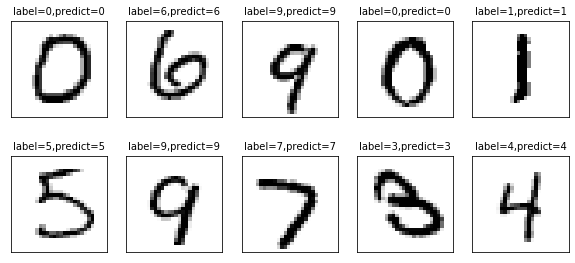

In [22]:
prediction_result=sess.run(tf.argmax(pred,1), # 由于pred预测结果是one-hot编码格式，所以需要转换为0~9数字
                           feed_dict={x: mnist.test.images })
plot_images_labels_prediction(mnist.test.images,
                              mnist.test.labels,
                              prediction_result,10)

## 找出预测错误

In [23]:
count=0
for i in range(500):
    if prediction_result[i]!=np.argmax(mnist.test.labels[i]):
        print("i="+str(i)+
              "   label=",np.argmax(mnist.test.labels[i]),
              "predict=",prediction_result[i])
        count+=1
print("count=", count)
    

i=63   label= 3 predict= 2
i=66   label= 6 predict= 7
i=100   label= 6 predict= 1
i=118   label= 9 predict= 2
i=139   label= 4 predict= 8
i=149   label= 2 predict= 3
i=193   label= 9 predict= 8
i=233   label= 8 predict= 7
i=241   label= 9 predict= 8
i=245   label= 3 predict= 5
i=247   label= 4 predict= 2
i=259   label= 6 predict= 0
i=268   label= 8 predict= 3
i=300   label= 4 predict= 6
i=320   label= 9 predict= 1
i=321   label= 2 predict= 3
i=324   label= 0 predict= 5
i=340   label= 5 predict= 3
i=381   label= 3 predict= 2
i=403   label= 8 predict= 5
i=412   label= 5 predict= 3
i=425   label= 4 predict= 2
i=432   label= 4 predict= 5
i=448   label= 9 predict= 8
i=449   label= 3 predict= 5
i=464   label= 3 predict= 7
i=478   label= 5 predict= 6
i=479   label= 9 predict= 5
count= 28


In [17]:
sess.close()

## 实验题
### 实验题1：改变训练的相关参数，如batch_size和train_epochs，观察训练结果的变化，再增加一些代码，用TensorBoard看看，分析一下原因。